In [2]:
import os
import io
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import Audio

In [3]:
DATASET_BASE_PATH = "D:/datasets/SpeechProcessing/output_folder_trial"
SEED = 1337
EPOCHS = 10
BATCH_SIZE = 64
VALIDATION_RATIO = 0.1

In [4]:
# Set all random seeds in order to get reproducible results
keras.utils.set_random_seed(SEED)
data_folder_path_tvm = os.path.join(DATASET_BASE_PATH, 'Trivandrum')
data_folder_path_koz = os.path.join(DATASET_BASE_PATH, 'Kozhikode')
data_folder_path_koz = os.path.join(DATASET_BASE_PATH, 'Kottayam')
data_folder_path_koz = os.path.join(DATASET_BASE_PATH, 'Trissur')


In [5]:
gender_agnostic_categories = [
    "tvm",
    "koz"
    "kot"
    "tri"
]
class_names = [
    "Trivandrum",
    "Kozhikode"
    "Kottayam",
    "Trissur"
]

In [6]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

In [7]:
def list_files_recursive(directory):
    """List full file paths in a directory and its subdirectories for '.wav' files."""
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Define the base directories for each accent
base_dir_accent1 = "D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum"
base_dir_accent2 = "D:/datasets/SpeechProcessing/output_folder_trial/Kozhikode"
base_dir_accent3 = "D:/datasets/SpeechProcessing/output_folder_trial/Kottayam"
base_dir_accent4 = "D:/datasets/SpeechProcessing/output_folder_trial/Trissur"

# List files in each base directory including subdirectories
files_accent1 = list_files_recursive(base_dir_accent1)
files_accent2 = list_files_recursive(base_dir_accent2)
files_accent3 = list_files_recursive(base_dir_accent3)
files_accent4 = list_files_recursive(base_dir_accent4)

# Create a DataFrame
data = {'filename': files_accent1 + files_accent2 + files_accent3 + files_accent4 ,
        'accent': [0] * len(files_accent1) + [1] * len(files_accent2) + [2] * len(files_accent3) + [3] * len(files_accent4)}
dataframe = pd.DataFrame(data)

# Shuffle the DataFrame
dataframe = dataframe.sample(frac=1, random_state=1337).reset_index(drop=True)

# Display the first few rows of the DataFrame
print(dataframe.head())

# Display some file paths to verify they include nested directories
print(dataframe['filename'].head(10))
dataframe.to_csv('D:\datasets\SpeechProcessing\dataframe.csv', index=False)



Empty DataFrame
Columns: [filename, accent]
Index: []
Series([], Name: filename, dtype: float64)


OSError: Cannot save file into a non-existent directory: 'D:\datasets\SpeechProcessing'

In [60]:
import os

def count_chunks(directory):
    """Count the number of chunks (.wav files) within each subdirectory of a directory."""
    accent_chunks = {}
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            subdirectory = os.path.join(root, dir_name)
            chunk_count = sum([1 for f in os.listdir(subdirectory) if f.endswith('.wav')])
            accent_chunks[subdirectory] = chunk_count
    return accent_chunks

# Define the base directories for each accent
base_dir_accent1 = "D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum"
base_dir_accent2 = "D:/datasets/SpeechProcessing/output_folder_trial/Kozhikode"
base_dir_accent3 = "D:/datasets/SpeechProcessing/output_folder_trial/Kottayam"
base_dir_accent4 = "D:/datasets/SpeechProcessing/output_folder_trial/Trissur"

# Count the number of chunks for each accent
chunks_accent1 = count_chunks(base_dir_accent1)
chunks_accent2 = count_chunks(base_dir_accent2)
chunks_accent3 = count_chunks(base_dir_accent3)
chunks_accent4 = count_chunks(base_dir_accent4)

# Print the results
print("Trivandrum chunks:")
for subdirectory, count in chunks_accent1.items():
    print(f"{subdirectory}: {count} .wav files")

print("\nKozhikode chunks:")
for subdirectory, count in chunks_accent2.items():
    print(f"{subdirectory}: {count} .wav files")

print("\nKottayam chunks:")
for subdirectory, count in chunks_accent3.items():
    print(f"{subdirectory}: {count} .wav files")

print("\nTrissur chunks:")
for subdirectory, count in chunks_accent4.items():
    print(f"{subdirectory}: {count} .wav files")


Trivandrum chunks:
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_01: 39 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_01 - Copy: 39 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_02: 55 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_02 - Copy: 55 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_03: 64 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_03 - Copy: 64 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_04: 44 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_04 - Copy: 44 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_05: 39 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_05 - Copy: 39 .wav files
D:/datasets/SpeechProcessing/output_folder_trial/Trivandrum\Tvm_06: 39 .wav files
D:/datasets/SpeechProcessing/output_folder_t

In [61]:
split = int(len(dataframe) * (1 - VALIDATION_RATIO))
train_df = dataframe[:split]
valid_df = dataframe[split:]

print(
    f"We have {train_df.shape[0]} training samples & {valid_df.shape[0]} validation ones"
)

We have 5977 training samples & 665 validation ones


In [62]:
# # Normalize audio data
# def normalize_audio(audio):
#     return audio / np.max(np.abs(audio))
# # 
# # Assuming x_valid contains raw audio data
# x_valid = normalize_audio(x_valid)


In [63]:
print(train_df.dtypes)
print(valid_df.dtypes)

filename    object
accent       int64
dtype: object
filename    object
accent       int64
dtype: object


In [64]:

@tf.function
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)

    return audio_wav



def filepath_to_embeddings(filename, label):
    audio_wav = load_16k_audio_wav(filename)
    scores, embeddings, _ = yamnet_model(audio_wav)
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(tf.cast(label, tf.int32), embeddings_num)

    # Ensure both choices in tf.where are of the same type
    not_speech_label = tf.constant(len(class_names) - 1, dtype=tf.int32)
    labels = tf.where(tf.argmax(scores, axis=1) == 0, labels, not_speech_label)

    return (embeddings, tf.one_hot(labels, len(class_names)))



def dataframe_to_dataset(dataframe, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["filename"], dataframe["accent"])
    )

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)



train_ds = dataframe_to_dataset(train_df)
valid_ds = dataframe_to_dataset(valid_df)

In [65]:
import keras
from keras import layers

keras.backend.clear_session()

def build_and_compile_model():
    inputs = keras.layers.Input(shape=(1024,), name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3, name="dropout_1")(x)

    x = keras.layers.Dense(256, activation="relu", name="dense_2")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3, name="dropout_2")(x)

    x = keras.layers.Dense(128, activation="relu", name="dense_3")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3, name="dropout_3")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Start with a lower learning rate
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model

model = build_and_compile_model()
model.summary()


Model: "accent_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                

In [66]:
# class_weight = {0: 10, 1: 1}

In [67]:
MODEL_NAME = "Malayalam_accent_recognition"
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=10, restore_best_weights=True
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".h5", monitor="val_auc", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

def lr_scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [86]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
import keras

# Early stopping to prevent overfitting
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler to adjust the learning rate during training
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(scheduler)

callbacks = [early_stopping_cb, lr_callback]

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # Adjust the learning rate if needed
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

# Train the model
history = model.fit(
    train_ds,
    epochs=20,  # Increase the number of epochs
    validation_data=valid_ds,
    # class_weight=class_weight,  # Ensure class weights are applied if there is class imbalance
    callbacks=callbacks,
    verbose=2,
)


Epoch 1/20
1886/1886 - 29s - loss: 0.8399 - accuracy: 0.6802 - auc: 0.7999 - val_loss: 2.0106 - val_accuracy: 0.5497 - val_auc: 0.6588 - lr: 0.0010 - 29s/epoch - 15ms/step
Epoch 2/20
1886/1886 - 27s - loss: 0.8388 - accuracy: 0.6791 - auc: 0.8007 - val_loss: 2.4478 - val_accuracy: 0.5497 - val_auc: 0.5977 - lr: 0.0010 - 27s/epoch - 15ms/step
Epoch 3/20
1886/1886 - 27s - loss: 0.8657 - accuracy: 0.6786 - auc: 0.7994 - val_loss: 2.4569 - val_accuracy: 0.5497 - val_auc: 0.5908 - lr: 0.0010 - 27s/epoch - 14ms/step
Epoch 4/20
1886/1886 - 27s - loss: 0.8718 - accuracy: 0.6797 - auc: 0.7996 - val_loss: 2.2174 - val_accuracy: 0.5497 - val_auc: 0.6147 - lr: 0.0010 - 27s/epoch - 15ms/step
Epoch 5/20
1886/1886 - 27s - loss: 0.8891 - accuracy: 0.6769 - auc: 0.7970 - val_loss: 1.5198 - val_accuracy: 0.5243 - val_auc: 0.6425 - lr: 0.0010 - 27s/epoch - 14ms/step
Epoch 6/20
1886/1886 - 27s - loss: 0.9010 - accuracy: 0.6751 - auc: 0.7964 - val_loss: 2.6791 - val_accuracy: 0.5497 - val_auc: 0.6214 - lr:

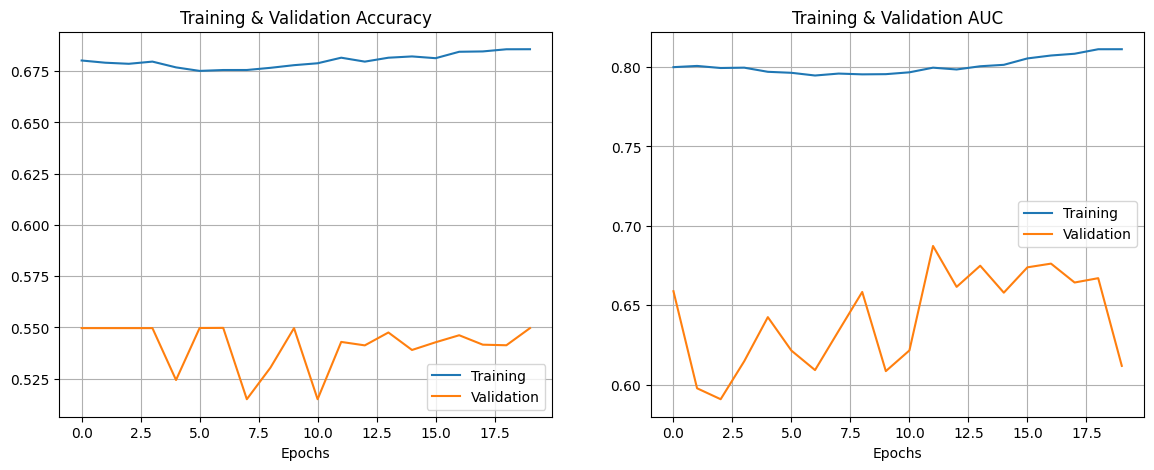

In [87]:
import matplotlib.pyplot as plt

# Use the length of the history object to handle early stopping
epochs = range(len(history.history["accuracy"]))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot Training and Validation Accuracy
axs[0].plot(epochs, history.history["accuracy"], label="Training")
axs[0].plot(epochs, history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

# Plot Training and Validation AUC
axs[1].plot(epochs, history.history["auc"], label="Training")
axs[1].plot(epochs, history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()


In [88]:
train_loss, train_acc, train_auc = model.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = model.evaluate(valid_ds)

279/279 [==============================] - 1s 5ms/step - loss: 1.0857 - accuracy: 0.5497 - auc: 0.6118


In [89]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
    
)

train d-prime: 1.094, validation d-prime: 0.401


In [92]:
# Verify unique classes in the validation set
print(f"Unique classes in validation labels: {np.unique(np.argmax(y_valid, axis=1))}")

# Ensure the training data does not include validation data
print(f"Unique classes in training labels: {np.unique(train_df['accent'])}")

# Check if data is shuffled
print("Checking if training data is shuffled...")
print(train_df.head(10))


Unique classes in validation labels: [0 1 2]
Unique classes in training labels: [0 1 2 3]
Checking if training data is shuffled...
                                            filename  accent
0  D:/datasets/SpeechProcessing/output_folder_tri...       0
1  D:/datasets/SpeechProcessing/output_folder_tri...       1
2  D:/datasets/SpeechProcessing/output_folder_tri...       3
3  D:/datasets/SpeechProcessing/output_folder_tri...       2
4  D:/datasets/SpeechProcessing/output_folder_tri...       3
5  D:/datasets/SpeechProcessing/output_folder_tri...       3
6  D:/datasets/SpeechProcessing/output_folder_tri...       3
7  D:/datasets/SpeechProcessing/output_folder_tri...       1
8  D:/datasets/SpeechProcessing/output_folder_tri...       2
9  D:/datasets/SpeechProcessing/output_folder_tri...       1
